In [157]:
import math
import operator
import sys
from collections import defaultdict

import numpy as np
import cv2

import scipy.spatial as spatial
import scipy.cluster as clstr

import matplotlib.pyplot as plt



In [158]:

def resize_image(img, max_width=1000):
    """
    Resizes image to a maximum width of 800px
    """
    h, w = img.shape[:2]
    if w > max_width:
        scale = max_width / float(w)
        return cv2.resize(img, (int(w*scale), int(h*scale)))
    return img


def order_points_clockwise(pts):
    # pts: (4,2)
    rect = np.zeros((4,2), dtype="float32")
    # sum and diff method
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]   # top-left
    rect[2] = pts[np.argmax(s)]   # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect  # [tl, tr, br, bl]


def debug_show(step, img, points=None, size=7):
    """
    Display an image during processing with optional point overlays.

    step: string title for the step
    img: image to display
    points: array of (x, y) points to overlay (optional)
    """
    plt.figure(figsize=(size, size))
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')

    if points is not None:
        pts = np.array(points)
        plt.scatter(pts[:, 0], pts[:, 1], c='red', s=30)

    plt.title(step)
    plt.axis('off')
    plt.show()



def apply_corner_offsets(corners, topOffset=0, leftOffset=0, rightOffset=0):
    """
    Shift only the TOP corners outward to include more piece area.
    """

    # Corners come in order: [TL, TR, BL, BR]
    TL, TR, BL, BR = corners

    # Shift upward
    TL[1] -= topOffset
    TR[1] -= topOffset

    # Optional: expand horizontally
    TL[0] -= leftOffset
    TR[0] += rightOffset

    BL[0] -= leftOffset
    BR[0] += rightOffset

    return [TL, TR, BL, BR]

In [159]:

def sort_lines(lines):
    """
    Sorts lines by horizontal and vertical
    """
    h = []
    v = []
    for i in range(lines.shape[0]):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v.append([rho, theta])
        else:
            h.append([rho, theta])
    return h, v


def calculate_intersections(h, v):
    """
    Finds the intersection of two lines given in Hesse normal form.
    See https://stackoverflow.com/a/383527/5087436
    """
    points = []
    for rho1, theta1 in h:
        for rho2, theta2 in v:
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            point = np.linalg.solve(A, b)
            point = int(np.round(point[0])), int(np.round(point[1]))
            points.append(point)
    return np.array(points)


def cluster_intersections(points, max_dist=40):
    # I want to change this to kmeans
    Y = spatial.distance.pdist(points)
    Z = clstr.hierarchy.single(Y)
    T = clstr.hierarchy.fcluster(Z, max_dist, 'distance')
    clusters = defaultdict(list)
    for i in range(len(T)):
        clusters[T[i]].append(points[i])
    clusters = clusters.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), clusters)

    result = []
    for point in clusters:
        result.append([point[0], point[1]])
    return result


def find_chessboard_corners(points,topOffset):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0] + pt[1] for pt in points]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0] + pt[1] for pt in points]), key=operator.itemgetter(1)) 
    bottom_left, _ = min(enumerate([pt[0] - pt[1] for pt in points]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0] - pt[1] for pt in points]), key=operator.itemgetter(1)) 
    return [points[top_left], points[top_right], points[bottom_left], points[bottom_right]] 


def distance_between(p1, p2):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def warp_image(img, edges):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    top_left, top_right, bottom_left, bottom_right = edges[0], edges[1], edges[2], edges[3]

    # Explicitly set the data type to float32 or 'getPerspectiveTransform' will throw an error
    warp_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    warp_dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(warp_src, warp_dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))






def render_lines(img, lines, color):
    for rho, theta in lines:
        a = math.cos(theta)
        b = math.sin(theta)
        x0, y0 = a * rho, b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        cv2.line(img, pt1, pt2, color, 1, cv2.LINE_AA)


def render_intersections(img, points, color, size):
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), 2, color, size)




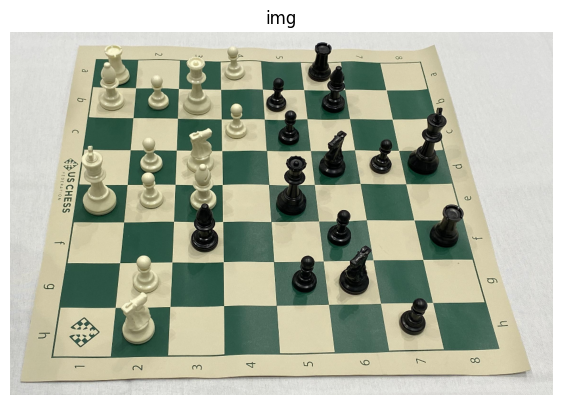

In [160]:
src_path = 'boards/board.jpg'
output_path = "output/"
output_prefix=""
src = cv2.imread(src_path)

if src is None:
    sys.exit("There is no file with this path!")

src = resize_image(src)

debug_show("img", src)

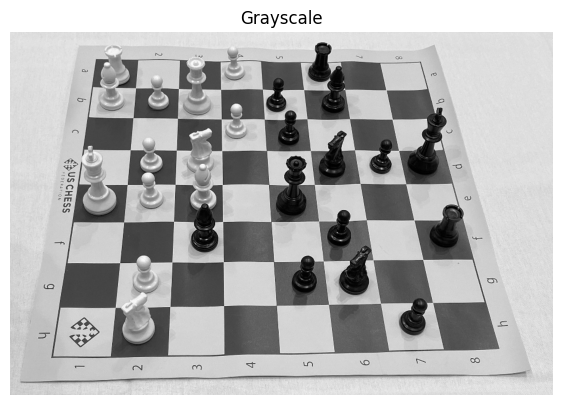

In [161]:
# --- 1: Grayscale ---
process = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

debug_show("Grayscale", process)

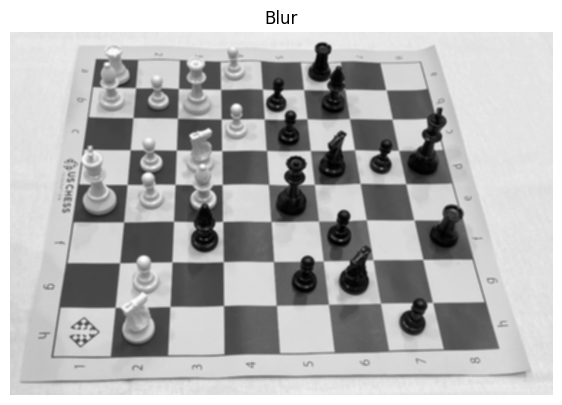

In [162]:
# --- 2: Blur ---
process = cv2.blur(process, (5, 5))

debug_show("Blur", process)

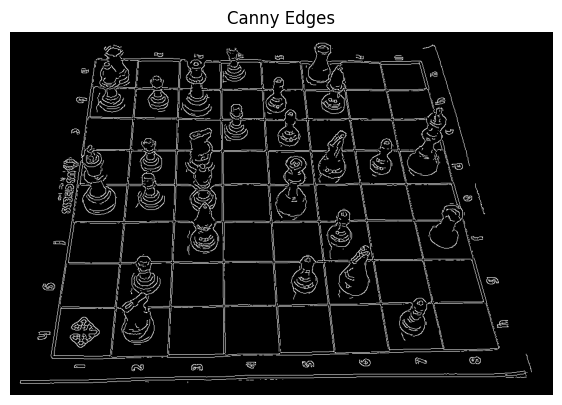

In [163]:
# --- 3: Canny ---
process = cv2.Canny(process, 50, 70)
debug_show("Canny Edges", process)

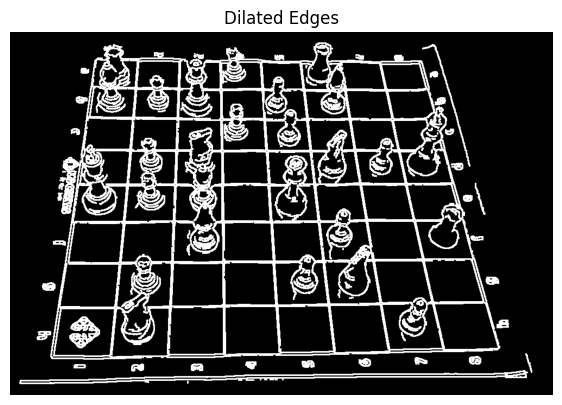

In [164]:
# --- 4: Dilate ---
process = cv2.dilate(process, np.ones((3, 3), dtype=np.uint8))

debug_show("Dilated Edges", process)

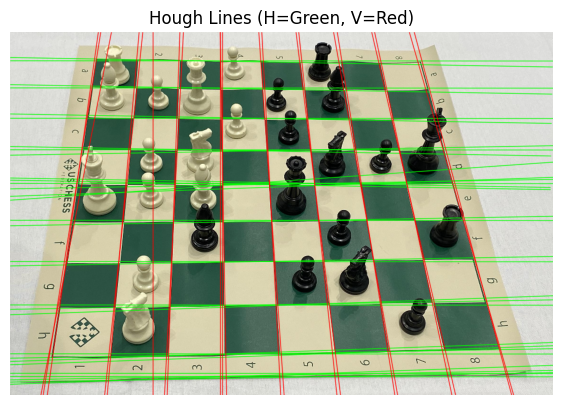

In [165]:
# --- 5: Hough Lines ---
rho, theta, thresh = 2, np.pi / 180, 700
lines = cv2.HoughLines(process, rho, theta, thresh)
h, v = sort_lines(lines)


tmp = src.copy()
render_lines(tmp, h, (0, 255, 0))
render_lines(tmp, v, (0, 0, 255))
debug_show("Hough Lines (H=Green, V=Red)", tmp)

if len(h) < 9 or len(v) < 9:
    print("Warning: Not enough horizontal/vertical lines.")

C:\Users\aktha\AppData\Local\Temp\ipykernel_12312\1210785567.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))


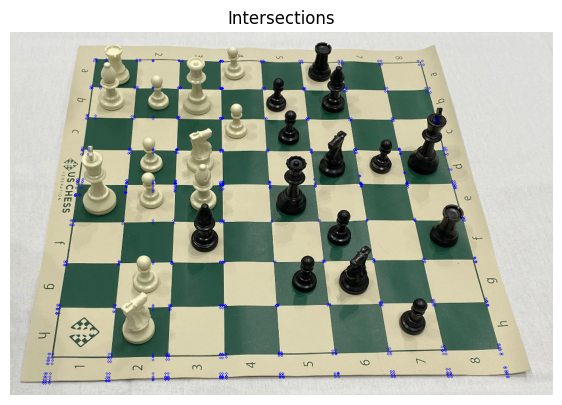

In [166]:
# --- 6: Intersections ---
intersections = calculate_intersections(h, v)

tmp = src.copy()
render_intersections(tmp, intersections, (255, 0, 0), 1)
debug_show("Intersections", tmp)

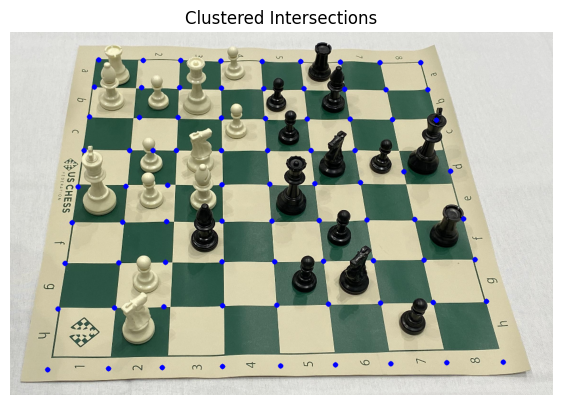

In [167]:
# --- 7: Cluster intersections ---
clustered = cluster_intersections(intersections)

tmp = src.copy()
render_intersections(tmp, clustered, (255, 0, 0), 5)
debug_show("Clustered Intersections", tmp)

if len(clustered) != 81:
        print(f"Warning: Expected 81 clusters, got {len(clustered)}")

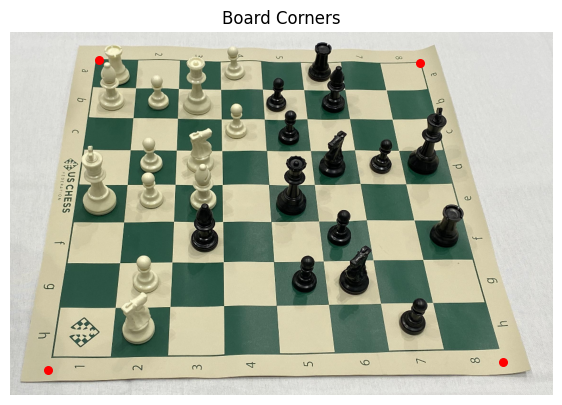

In [168]:
# --- 8: Outer Corners ---
topOffset,leftOffset,rightOffset =0,0,0
corners = find_chessboard_corners(clustered,topOffset=50)
cornersPadded = apply_corner_offsets(corners,topOffset,leftOffset,rightOffset)

tmp = src.copy()
debug_show("Board Corners", tmp, points=corners)

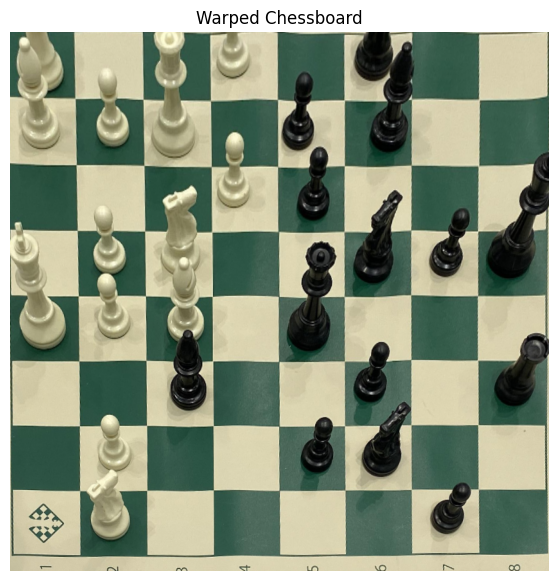

In [169]:

# --- 9: Warp ---
dst = warp_image(src, corners)

debug_show("Warped Chessboard", dst)




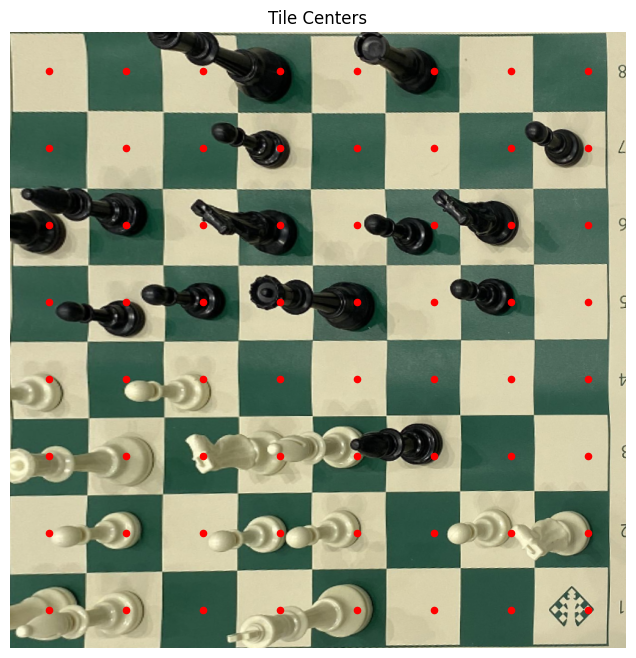

In [ ]:
dst = cv2.rotate(dst ,2)

def draw_tile_centers(dst):
    """
    Draws the centers of 8x8 tiles on the warped chessboard.
    
    Parameters:
        dst: warped square chessboard image
        top_offset_ratio: fraction of tile height to shift center downward (optional)
    """
    side = dst.shape[0]
    base_tile = side / 8
    centers = []

    for row in range(8):
        for col in range(8):
            # compute center coordinates
            cx = col * base_tile + base_tile / 2
            cy = row * base_tile + base_tile / 2

            centers.append((cx, cy))
    
    # plot
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    for (cx, cy) in centers:
        plt.scatter(cx, cy, c='red', s=20)
    plt.axis('off')
    plt.title("Tile Centers")
    plt.show()

    return centers

# --- usage ---
centers = draw_tile_centers(dst)  

.